# Meridional Overturning Circulation

This recipe shows an example of calculating the zonally-averaged global meridional overturning circulation using output from `MOM6`. We compute the overturning circulation both in density--latitude and depth--latitude space. We also plot separate basin-averaged overturning streamfunctions.

**Requirements:** The `conda/analysis3-25.06` (or later) module on ARE. We recommend an ARE session with more than 14 cores to make these computations. Ideally, use a whole Gadi compute node from `normalbw`, i.e., 28 cores.


#### ‼️ ⚠️ 🚨 Caveats 🚨 ⚠️ ‼️
The computations presented in this recipe suffer from _two_ issues in the Arctic ocean region, north of 65$^\circ$N:

1. The overturning metrics in this notebook do not use correct zonal averaging in the tripole region, north of 65$^\circ$N! See https://cosima-recipes.readthedocs.io/en/latest/02-Appetisers/True_Zonal_Mean.html for a recipe explainig how to properly average quantities in the zonal direction when the north of 65$^\circ$N.

2. The notion of vector quantities is distorted north of 65$^\circ$N, because north of 65$^\circ$N the grid cells' local `x`- and `y`- directions do not align with lines of constant latitude and longitude. Therefore `v` no longer gives the true meridional transport north of 65ᵒN. To correctly compute the overturning north of 65$^\circ$N, we would need to rotate the volume transports in the local `x`- and `y`-directions to obtain the corresponding transports in the zonal and meridional direction. For that reason, **all computations done in this notebook are wrong north of 65**$^\circ$**N**, and we only show latitudes south of 65$^\circ$N in the plots. See https://github.com/COSIMA/cosima-recipes/issues/510 for more details.

## Information needed to adapt to MOM5:

Diagnostics needed:

* `ty_trans_rho`: meridional transport binned online into `rho2` layers. This is on the same grid as `vmo`, i.e. the centre of the northern tracer cell's face.
* `pot_rho_2`: potential density referenced to 2000 metres needed to remapping the overturning to depth coordinates.

**Notes**

For low-resolution `MOM5`-based runs that include mesoscale eddy flux parameterisations, we need to explicitly include the volume transport from the Gent--McWilliams eddy parameterisation (`ty_trans_rho_gm`). This transport is already cumulatively summed in the vertical, so it needs to be added after the cumulative sum of `psi`. For `MOM6` we don't need to worry about this, because it is already included in `vmo`. Similarly for `MOM5`, the parameterised submesoscale meridional transport (`ty_trans_submeso`) is not explicitly included. However, it tends to be relatively unimportant for the deep circulation, which is where we are primarily interested, so we are probably can safely ignore it. Again, for `MOM6`, this is conveniently already included in the `vmo` output.

## MOM6 Recipe:

In [1]:
import numpy as np
import xarray as xr

from dask.distributed import Client

import matplotlib.pyplot as plt
import cmocean as cm

import intake
cat = intake.cat.access_nri

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45345,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35319,Total threads: 1
Dashboard: /proxy/43943/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:37483,


For this example, we are using 1 year of a 0.25° control simulation. If you want to increase the resolution or integrate over a longer time you might need a bigger ARE session.

First we load up `vmo` and sum in the zonal direction.

Most ACCESS-OM2 and MOM6 simulations output mass transport (with units of kg/s), so we convert to volume transport, i.e., to Sverdrup (Sv = 10$^6$ m$^3$/s).

In [3]:
experiment = "OM4_025.JRA_RYF"
start_time = "1990-01-01"
end_time = "1990-12-31"

# We need to specify "file_id" here, because there is "vmo" saved both on depth and density coordinates. 
# ".*" here is wildcard to ensure that the filenames contain "rho2_l", i.e., the density coordinate name.
df = cat[experiment].search(variable="vmo", frequency="1mon", file_id=".*rho2_l.*")
vmo = df.to_dask(xarray_open_kwargs={"decode_timedelta": True}).vmo
vmo = vmo.sel(time=slice(start_time, end_time))

# convert mass transport -> volume transport and then convert units -> Sv
rho0 = 1035 # kg/m^3, average seawater density
psi = (vmo / rho0) / 1e6
psi.attrs["units"] = "Sv"

# sum in longitude:
psi_sum_lon = psi.sum("xh")

# Cumulatively sum the transport in the vertical, time average and load.
# Note that we want to sum from the bottom up, but .cumsum sums from the top down,
# which is why we substract the sum in the second term here:
psi_avg = psi_sum_lon.cumsum("rho2_l") - psi_sum_lon.sum("rho2_l")
psi_avg = psi_avg.mean("time")
psi_avg = psi_avg.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Plotting in density coordinates

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution.

In [4]:
def levels_and_colorbarticks(max_value):
    """ Return the levels and the colorbarticks for the streamfunction plot.
    It may seem complicated but the truth is we just want to avoid the 0 contour
    so that the plot looks soothing to the eye. 
    Note this function can result in mismatched contour levels and ticks if you 
    change max_psi below to be an even number. """

    levels = np.hstack((np.arange(-max_value, 0, 2), np.flip(-np.arange(-max_value, 0, 2))))
    cbarticks = np.hstack((np.flip(-np.arange(3, max_value, 6)), np.arange(3, max_value, 6)))

    return levels, cbarticks

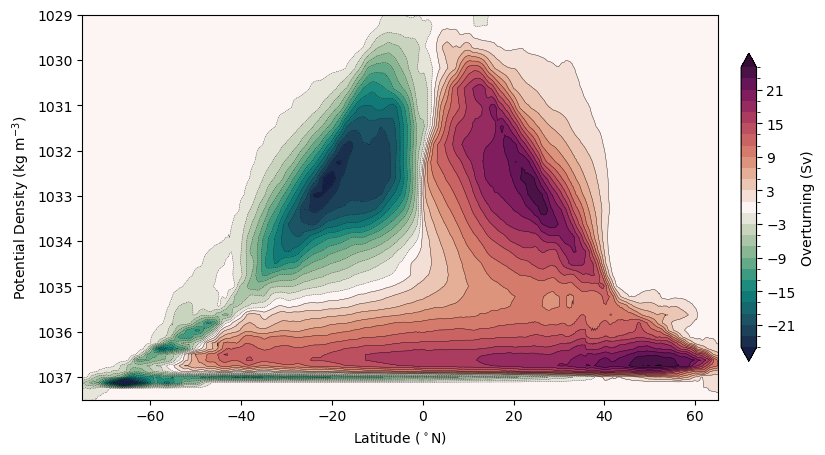

In [5]:
plt.figure(figsize=(10, 5))

# Best if this is an odd number - otherwise levels and cbarticks may be mismatched:
max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={
                          'shrink': 0.8, 
                          'label': 'Overturning (Sv)', 
                          'ticks': cbarticks,
                          'pad': 0.03,
                      })

psi_avg.plot.contour(levels=levels,
                     colors='k',
                     linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1029))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
# Limit to 65ᵒN, because calculations are wrong for region north of 65ᵒN, see https://github.com/COSIMA/cosima-recipes/issues/510
plt.xlim([-75, 65]);

Alternatively, you may want to stretch the y-axis to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

In [6]:
stretching_factor = 25 # A power value to set the stretching

# find minimum density:
rho_min = psi_avg.rho2_l.min()

psi_avg_plot = psi_avg.assign_coords({psi_avg.rho2_l.name: (psi_avg.rho2_l - rho_min)**stretching_factor})

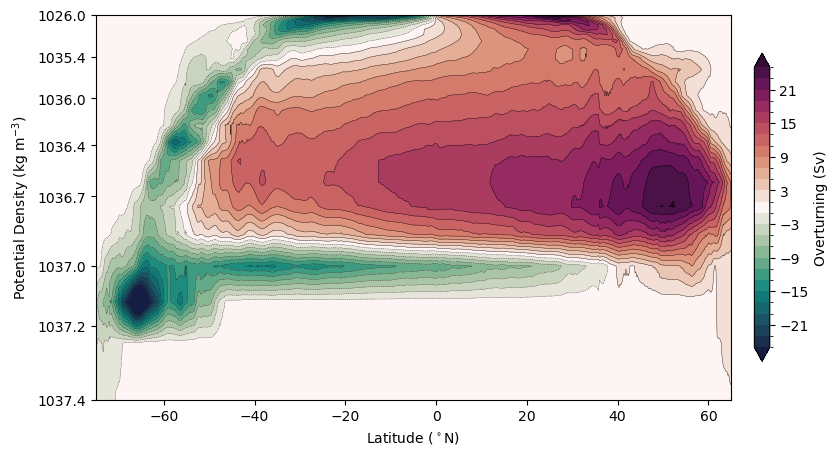

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

yticks = np.array([1026, 1035.4, 1036, 1036.4, 1036.7, 1037, 1037.2, 1037.4])

psi_avg_plot.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl,
                           extend='both',
                           cbar_kwargs={'shrink': 0.8,'label': 'Overturning (Sv)', 'ticks': cbarticks, 'pad': 0.03})

psi_avg_plot.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().set_yticks((yticks - rho_min.values)**stretching_factor)
plt.gca().set_yticklabels(yticks)

# ylims: a bit less than the minimum and a bit more than the maximum values
plt.gca().set_ylim([((yticks - rho_min.values).min() / 1.1)**stretching_factor, ((yticks - rho_min.values).max() * 1.0)**stretching_factor])
plt.gca().invert_yaxis()

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]); # calculations are wrong for region north of 65ᵒN

## Plotting in depth coordinates

Sometimes it's nice to see what this looks like in depth space, because it's a bit more intuitive. This requires remapping from density to depth space.

For the remapping first we need to load density.

Note that we currently don't have MOM6 output with `rhopot2` saved in the catalog. Once we do have that output, we can change this code to remove this function and gsw code and just load `rhopot2` directly.

In [8]:
def get_rho2(experiment, start_time, end_time):
    """ Load potential temperature `rhopot2` or compute it from temperature
    and salinity via the gsw package. """

    try:
        df = cat[experiment].search(variable="rhopot2", frequency="1mon")
        rho2 = df.to_dask(xarray_open_kwargs={"decode_timedelta": True}).rho_2.sel(time=slice(start_time, end_time))

    except ValueError:
        # If MOM6 experiment doesn't have rhopot2 output, we reconstruct it using the gsw package.
        import warnings
        import gsw
        warnings.warn("No 'potrho2' attribute found - constructing it on the fly using gsw")
        mom6_ts_ds = cat[experiment].search(variable=["thetao", 'so'], frequency="1mon")
        mom6_ts_ds = mom6_ts_ds.to_dask().sel(time=slice(start_time, end_time))
        
        potential_temp = mom6_ts_ds.thetao
        prac_salinity = mom6_ts_ds.so
        
        # convert to absolute salinity and conservative temperature before we can compute gsw.density.sigma2
        pressure = gsw.p_from_z(-potential_temp.z_l, potential_temp.yh)
        
        # convert pratical salinity (psu) to absolute salinity (g/kg)
        abs_salinity = gsw.SA_from_SP(prac_salinity, pressure, prac_salinity.xh, prac_salinity.yh)
        abs_salinity.attrs = {'units': 'Absolute Salinity (g/kg)'}

        # convert potential temperature (deg C) to conservative temperature (deg C)
        conservative_temp = gsw.CT_from_pt(prac_salinity, potential_temp)
        conservative_temp = conservative_temp.rename('thetao')
        conservative_temp.attrs = {'units': 'Conservative temperature (°C)'}
        
        # gsw.density.sigma2 returns the density *anomaly*, so add 1000 back on:
        rho2 = gsw.density.sigma2(abs_salinity, conservative_temp) + 1000

    return rho2

rho2 = get_rho2(experiment, start_time, end_time)

# time mean:
rho2 = rho2.mean('time')

/jobfs/151573273.gadi-pbs/ipykernel_792681/277404052.py:13: UserWarning: No 'potrho2' attribute found - constructing it on the fly using gsw
  warnings.warn("No 'potrho2' attribute found - constructing it on the fly using gsw")
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Before taking the zonal average of density, we mask the Mediterranean, so it doesn't bias things. We also need to interpolate density onto the same y-grid as psi.

In [9]:
# Mask the Mediterranean:
rho2 = rho2.where(((rho2.xh < 0)  | (rho2.xh > 45)) |
                  ((rho2.yh < 10) | (rho2.yh > 48)))
 
# zonal average and load:
rho2_zonal_mean = rho2.mean("xh").load()

# Interpolate rho2 onto yq grid:
rho2_zonal_mean = rho2_zonal_mean.interp(yh = psi_avg.yq)

In [10]:
# arctic and antarctic don't work for some reason, and also we don't want to plot 
# north of 65N due to incorrect zonal/meridional transport alignment anyway, 
# see https://github.com/COSIMA/cosima-recipes/issues/510:
psi_avg = psi_avg.sel(yq=slice(-78, 65))
rho2_zonal_mean = rho2_zonal_mean.sel(yq=slice(-78,65))

# initialise depth_array:
depth_array = 0 * psi_avg.copy(deep=True)
# set to max depth of ocean in your simulation:
max_depth = 6500 # metres

# loop through latitude and interpolate to find depth of each density coord:
for j, lat in enumerate(psi_avg.yq):
    # overwrite depth z_l coords with density values at this latitude:
    depth_of_rho2 = (rho2_zonal_mean.z_l).assign_coords({'z_l': rho2_zonal_mean.sel(yq=lat, method='nearest')})
    # drop nans beneath bathymetry:
    depth_of_rho2 = depth_of_rho2.where(~np.isnan(depth_of_rho2.z_l), drop=True)
    
    # as we interpolate, fill in nans at surface with depth 0 and fill nans at the bottom with depth max_depth:
    depth_array[:, j] = depth_of_rho2.interp(z_l = psi_avg.rho2_l, kwargs={"bounds_error": False, "fill_value": (0, max_depth)})
    
new_psi_avg = xr.DataArray(data = psi_avg.values,
                           dims = ['rhopot2', 'yq'],
                           coords = dict(yq=(["yq"], psi_avg.yq.values),
                                         depth=(["rhopot2", "yq"], depth_array.values)),
                           attrs = psi_avg.attrs)

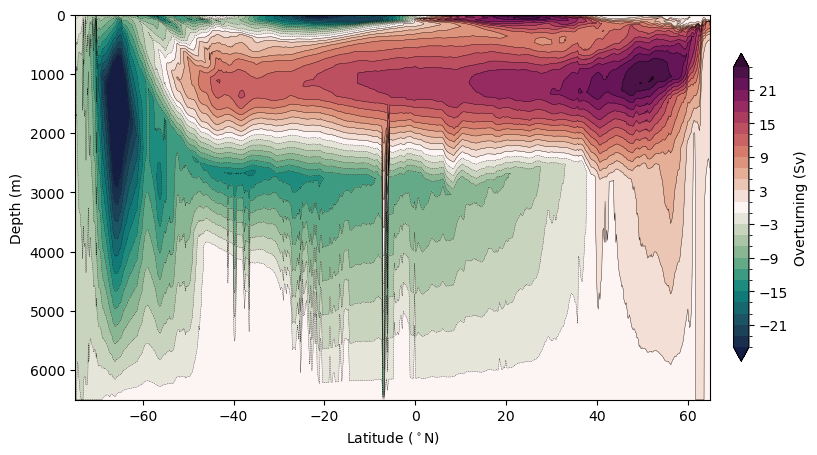

In [11]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

new_psi_avg.plot.contourf(y="depth",
                          levels=levels,
                          cmap=cm.cm.curl,
                          extend='both',
                          cbar_kwargs={'shrink': 0.8, 'label': 'Overturning (Sv)', 'ticks': cbarticks, 'pad': 0.03})

new_psi_avg.plot.contour(y="depth",
                         levels=levels,
                         colors='k',
                         linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]); # calculations are wrong for region north of 65ᵒN

__Note__: This has a few dodgy-looking contours - possibly because we used gsw to reconstruct the density from zonal average temperature and salinity. If this doesn't improve when we swap out to use `potrho2` output, we should look into this more. It could also be the depth / density interpolation.

# Atlantic and Indo-Pacific basin components of the Meridional Overturning Circulation

Here, we compute the zonally averaged meridional overturning streamfunction in density space in a similar fashion to the above, except that we partition the overturning circulation into the Atlantic and Indo-Pacific Basins. Strong North Atlantic deep water circulation in the Atlantic can sometimes obscure Antarctic Bottom Water circulation in the IndoPacific in global zonally-averaged calculations, something we can minimise by the masking procedure below.

Compute times were calculated using 28 cpus and 124 GB memory Jupyter Lab on gadi, using conda environment analysis3-25.06.

## 1. Create masks for the Atlantic and IndoPacific Basins

Here we want to create two masks; one that masks for the Southern Ocean south of 33$^\circ$S (around the bottom of Africa) and the Atlantic Ocean, and one that masks for the Southern Ocean south of 33$^\circ$S and the Indian plus Pacific Oceans.

A bit of fiddling is a little unavoidable here but the procedure below should be compatible with 0.25$^\circ$ or 1$^\circ$ grid data so you don't have to repeat the whole process.

To start with, load a single density layer of the overturning variable that we want to mask, because this is on the correct grid. We will make our mask from this.

In [12]:
vmo = cat[experiment].search(variable="vmo", frequency="1mon", file_id=".*rho2_l.*")
vmo = vmo.to_dask(xarray_open_kwargs={"use_cftime": True}).isel(time=0).isel(rho2_l=0).vmo

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [13]:
land_mask = ~vmo.isnull()

Now, let's draw in a set of meridians that lie within land masses separating the Atlantic basin from the Indo-Pacific basins, to show where our mask is going to go. We will also have a line to delineate the southern boundary.

Note that the problems with this mask are:
* It is not perfect at the Panama Canal; 
* The Great Australian Bight is not counted in the Southern Ocean; 
* The calculation is done on tracer points, but streamfunction is actually found on the northern edge of the tracer grid; and
* We have ignored the tripole, so zonal averages north of 65°N are not so meaningful. That is of no consequence for the Pacific, but more relevant for the Atlantic/Arctic sector.

These are all pretty minor issues for a global quantity like the overturning, but users should feel free to improve this if they like.

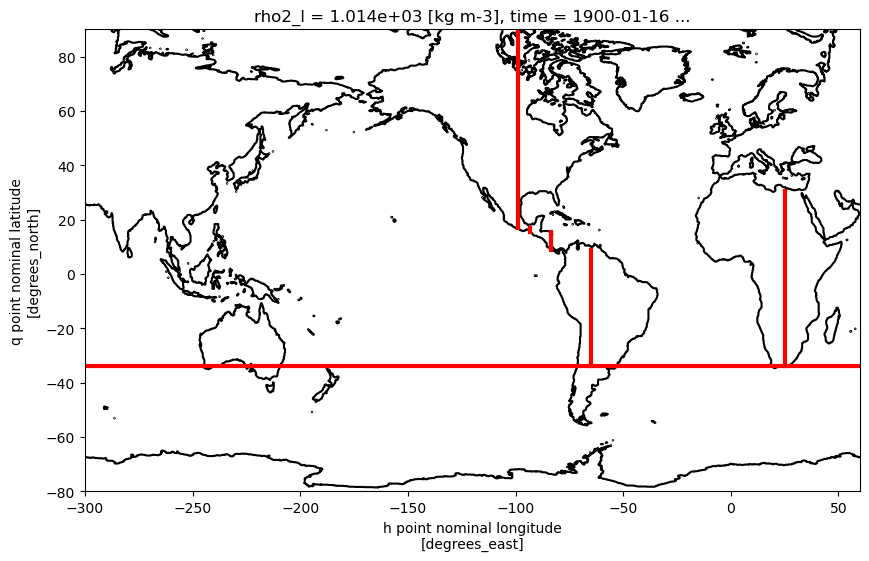

In [14]:
fig = plt.figure(2, (10, 6))
ax = plt.subplot()

land_mask.plot.contour(levels=[0.5], colors='k')

ax.plot([-300, 60], [-34,-34], 'r', linewidth = 3)
ax.plot([-65, -65], [-34, 9], 'r', linewidth = 3)
ax.plot([-83.7, -83.7], [9, 15.5], 'r', linewidth = 3)
ax.plot([-93.3, -93.3], [15.5, 17], 'r', linewidth = 3)
ax.plot([-99, -99], [17, 90], 'r', linewidth = 3)
ax.plot([25, 25], [-34,30.5], 'r', linewidth = 3)
ax.plot([79, 79], [30.5, 90], 'r', linewidth = 3)

ax.set_xlim([-300, 60])
ax.set_ylim([-80, 90]);

Now, let's make our masks along these dividing lines. Note that we include the Southern Ocean in both the Atlantic and the Indo-Pacific masks.

In [15]:
## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xh > -280).where(land_mask.xh < -65)).fillna(0)
indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xh > -280).where(land_mask.xh < -83.7)).fillna(0)
indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xh > -280).where(land_mask.xh < -93.3)).fillna(0)
indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xh > -280).where(land_mask.xh < -99)).fillna(0)
indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xh > 25).where(land_mask.xh < 80)).fillna(0)

indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)

atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)

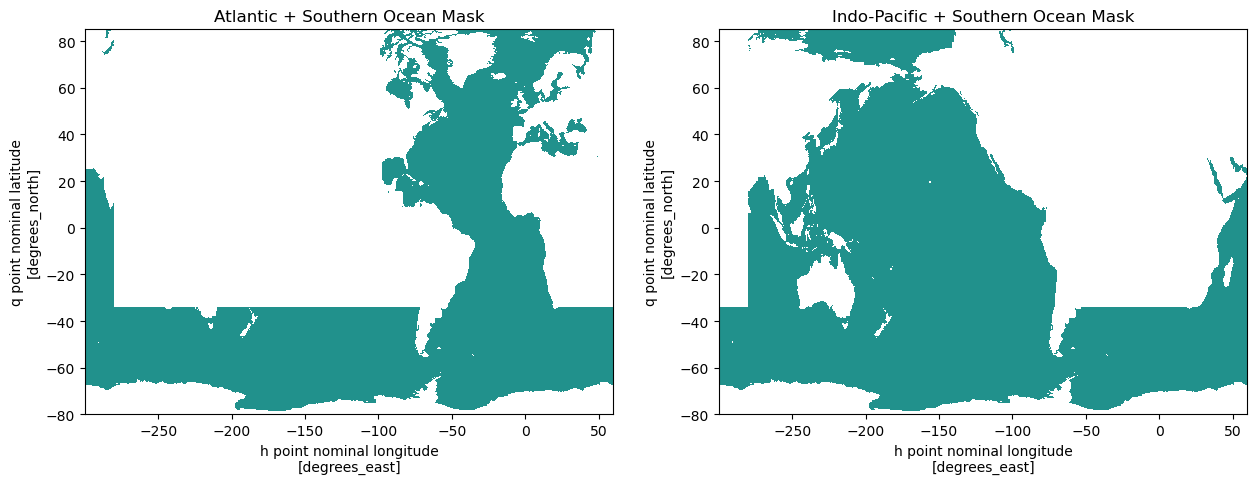

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

atlantic_sector_mask.plot(ax=ax[0], add_colorbar=False)
ax[0].set_ylim([-80, 85])
ax[0].set_title('Atlantic + Southern Ocean Mask')

indo_sector_mask.plot(ax=ax[1], add_colorbar=False)
ax[1].set_ylim([-80, 85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask');

## 2. Mask `psi` (we loaded above) by basin and compute basin-specific MOC

We use the `psi` from before, apply the mask and compute the basin-specific streamfunction in a similar manner as we did above.

In [17]:
# Atlantic-MOC
Atlantic_psi = (psi * atlantic_sector_mask).sum("xh")
Atlantic_psi = Atlantic_psi.cumsum("rho2_l") - Atlantic_psi.sum("rho2_l")
Atlantic_psi = Atlantic_psi.mean("time")
Atlantic_psi = Atlantic_psi.load()

# Indo-Pacific MOC
IndoPacific_psi = (psi * indo_sector_mask).sum("xh")
IndoPacific_psi = IndoPacific_psi.cumsum("rho2_l") - IndoPacific_psi.sum("rho2_l")
IndoPacific_psi = IndoPacific_psi.mean("time")
IndoPacific_psi = IndoPacific_psi.load()

## 3. Plotting

Now plot the output.

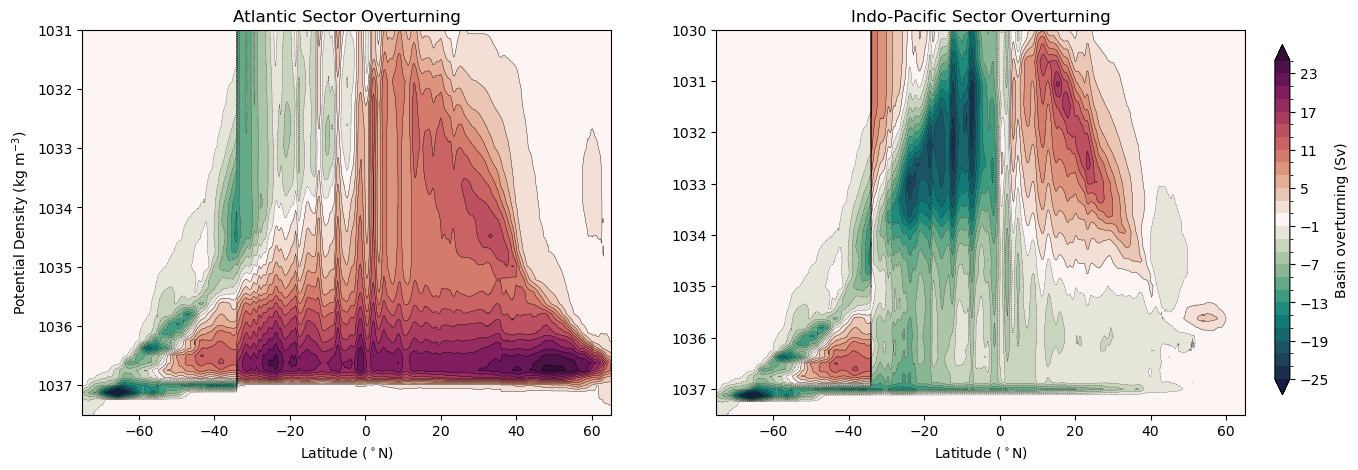

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Best if this is an odd number - otherwise levels and cbarticks may be mismatched:
max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

# Atlantic MOC
Atlantic_psi.plot.contourf(ax=ax[0],
                           levels=levels,
                           cmap=cm.cm.curl,
                           extend='both',
                           add_colorbar=False)
Atlantic_psi.plot.contour(ax=ax[0],
                          levels=levels,
                          colors='k',
                          linewidths=0.25)
ax[0].invert_yaxis()
ax[0].set_ylim((1037.5, 1031))
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude ($^\circ$N)')
ax[0].set_title('Atlantic Sector Overturning')

# Limit to 65ᵒN, because calculations are wrong for region north of 65ᵒN, see https://github.com/COSIMA/cosima-recipes/issues/510
ax[0].set_xlim([-75, 65])


# Indo-Pacific MOC
h = IndoPacific_psi.plot.contourf(ax=ax[1],
                                  levels=levels,
                                  cmap=cm.cm.curl,
                                  extend='both',
                                  add_colorbar=False)
IndoPacific_psi.plot.contour(ax=ax[1],
                             levels=levels,
                             colors='k',
                             linewidths=0.25)
ax[1].invert_yaxis()
ax[1].set_ylim((1037.5, 1030))
ax[1].set_ylabel('')
ax[1].set_xlabel('Latitude ($^\circ$N)')
ax[1].set_title('Indo-Pacific Sector Overturning')

# Limit to 65ᵒN, because calculations are wrong for region north of 65ᵒN, see https://github.com/COSIMA/cosima-recipes/issues/510
ax[1].set_xlim([-75, 65])

# Plot a colorbar
cax = plt.axes([0.92, 0.15, 0.01, 0.7])
cb = plt.colorbar(h, cax=cax, orientation='vertical')
cb.ax.set_ylabel('Basin overturning (Sv)');